In [1]:
!sudo apt-get install mcl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mcl is already the newest version (1:14-137+ds-9build2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [24]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 44.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import plotly.express as px
import kaleido
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
fasttext_vocab = pickle.load(open('./preprocessed/attribute.token-freqs.fasttext.info.pickle', "rb"))
sbert_vocab = pickle.load(open('./preprocessed/attribute.token-freqs.sbert.info.pickle', "rb"))
pbert_vocab = pickle.load(open('./preprocessed/attribute.token-freqs.pubmedbert.info.pickle', "rb"))

In [2]:
vocab_df1 = pd.DataFrame(columns=['model', 'field', 'tokens', 'uniq_tokens', '%tokens_found', '%uniq_found'])
vocab_df2 = pd.DataFrame(columns=['model', 'field', 'measure', 'value'])
for m, d in [('fasttext', fasttext_vocab), ('sbert', sbert_vocab), ('pbert', pbert_vocab)]:
    for k, v in d.items():
        i1 = vocab_df1.index.size
        i2 = vocab_df2.index.size
        field = k
        tokens = v['tokens']
        uniq = v['uniq']
        oovt = v['oov_tokens']
        oovu = v['oov_uniq']
        pcntid = 100*(tokens-oovt)/tokens
        pcntuid = 100*(uniq-oovu)/uniq
        vocab_df1.loc[i1] = [m, field, tokens, uniq, pcntid, pcntuid]
        vocab_df2.loc[i2] = [m, field, '%tokens_found', pcntid]
        vocab_df2.loc[i2+1] = [m, field, '%uniq_found', pcntuid]
print('df1', vocab_df1.index.size, vocab_df1.head())
print('df2', vocab_df2.index.size, vocab_df2.head())

df1 126       model                                  field  tokens  uniq_tokens  \
0  fasttext                       bio_material_sam   13213         9629   
1  fasttext  biological_material_preprocessing_sam     306          115   
2  fasttext                   collection_label_sam    1511         1485   
3  fasttext                           comments_sam    2479         1015   
4  fasttext                       conductivity_sam      47           22   

   %tokens_found  %uniq_found  
0      27.798380     6.013085  
1      90.849673    80.000000  
2       3.309067     1.952862  
3      80.153288    55.665025  
4      87.234043    72.727273  
df2 252       model                                  field        measure      value
0  fasttext                       bio_material_sam  %tokens_found  27.798380
1  fasttext                       bio_material_sam    %uniq_found   6.013085
2  fasttext  biological_material_preprocessing_sam  %tokens_found  90.849673
3  fasttext  biological_material_

In [3]:
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='deep',
              font='sans-serif',
              font_scale=1,
              color_codes=True, rc=None)

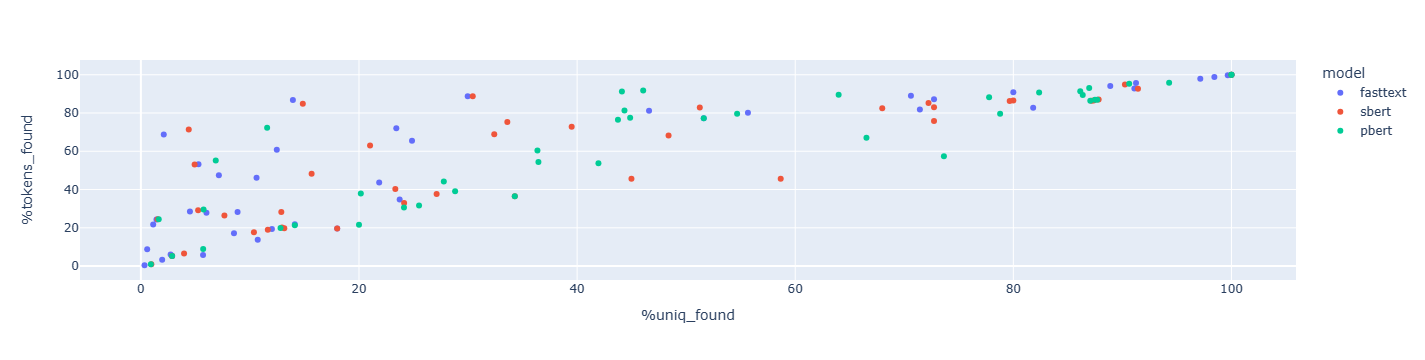

In [5]:
fig = px.scatter(vocab_df1,
                 x='%uniq_found',
                 y='%tokens_found',
                 color='model',
                 hover_data=['field', '%tokens_found', '%uniq_found'])
fig.show()
fig.write_image("vocab_scatter.png")

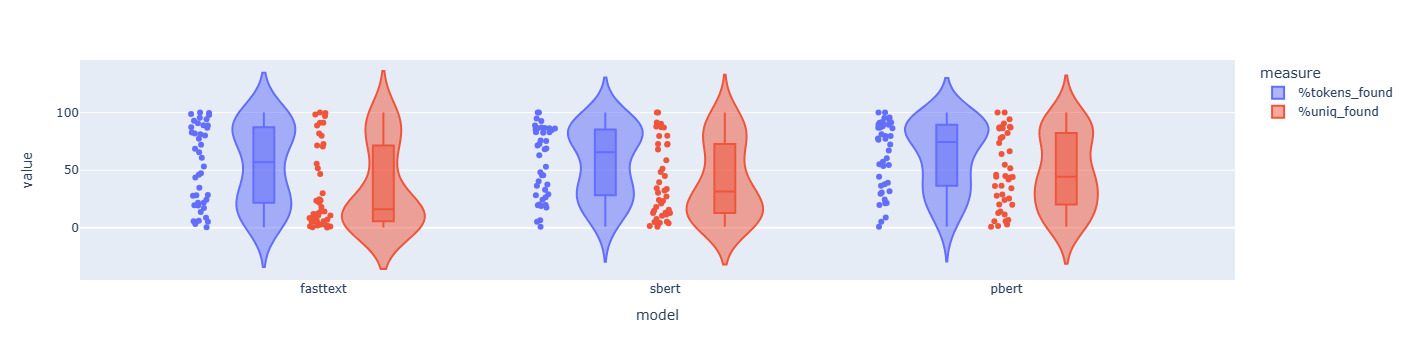

In [6]:
fig = px.violin(vocab_df2,
                y="value",
                x="model",
                color="measure",
                box=True,
                points="all",
          hover_data=vocab_df2.columns)
fig.show()
fig.write_image("vocab_violin.png")

bio_material_sam results not found at ./results/fasttext-similarity-matrix/fasttext-bio_material_sam.similarity-score-matrix.npy

biological_material_preprocessing_sam
1.0000006 0.0 0.39976767 1.0000005960464478
Estimated no. of clusters: 3
Estimated no. of noise points: 1
DBSCAN(eps=1.0000005961464478, min_samples=2)
silhouette score: 0.79466444


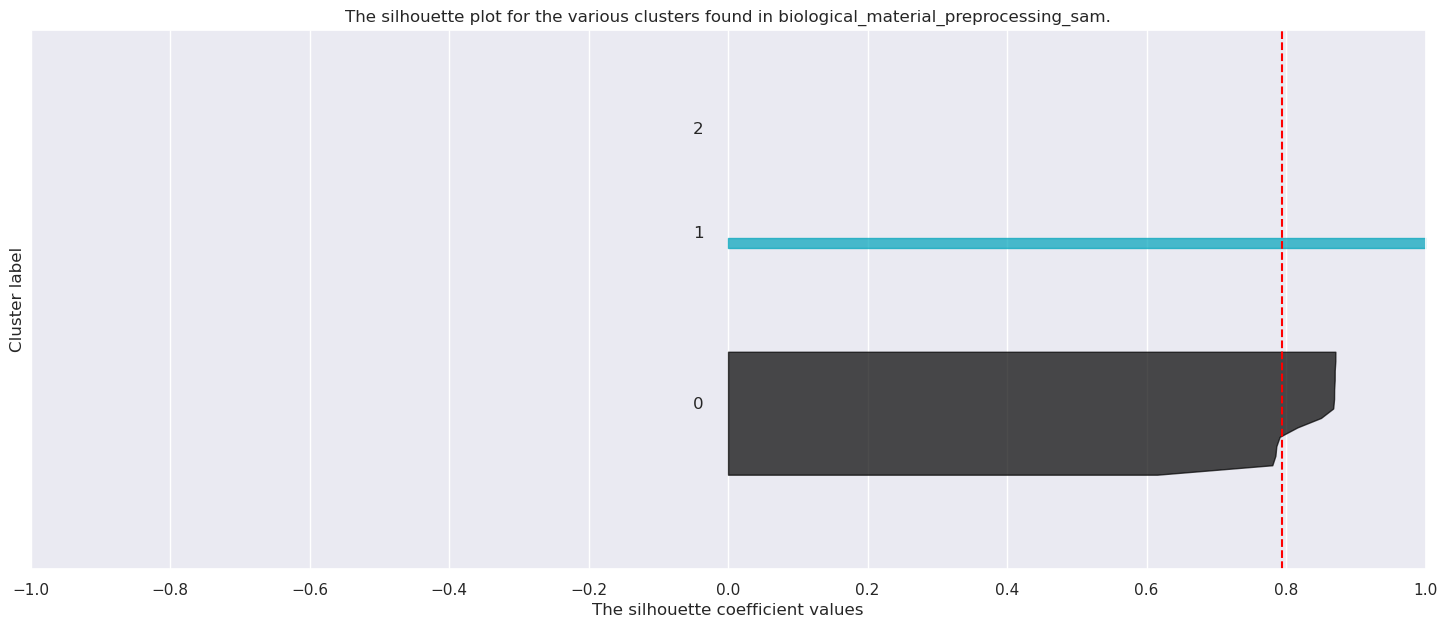


collection_label_sam
1.0000004 0.0 0.99984676 1.0000003576278687
Estimated no. of clusters: 8
Estimated no. of noise points: 2
DBSCAN(eps=1.0000003577278687, min_samples=2)
silhouette score: 0.98978394


<Figure size 640x480 with 0 Axes>

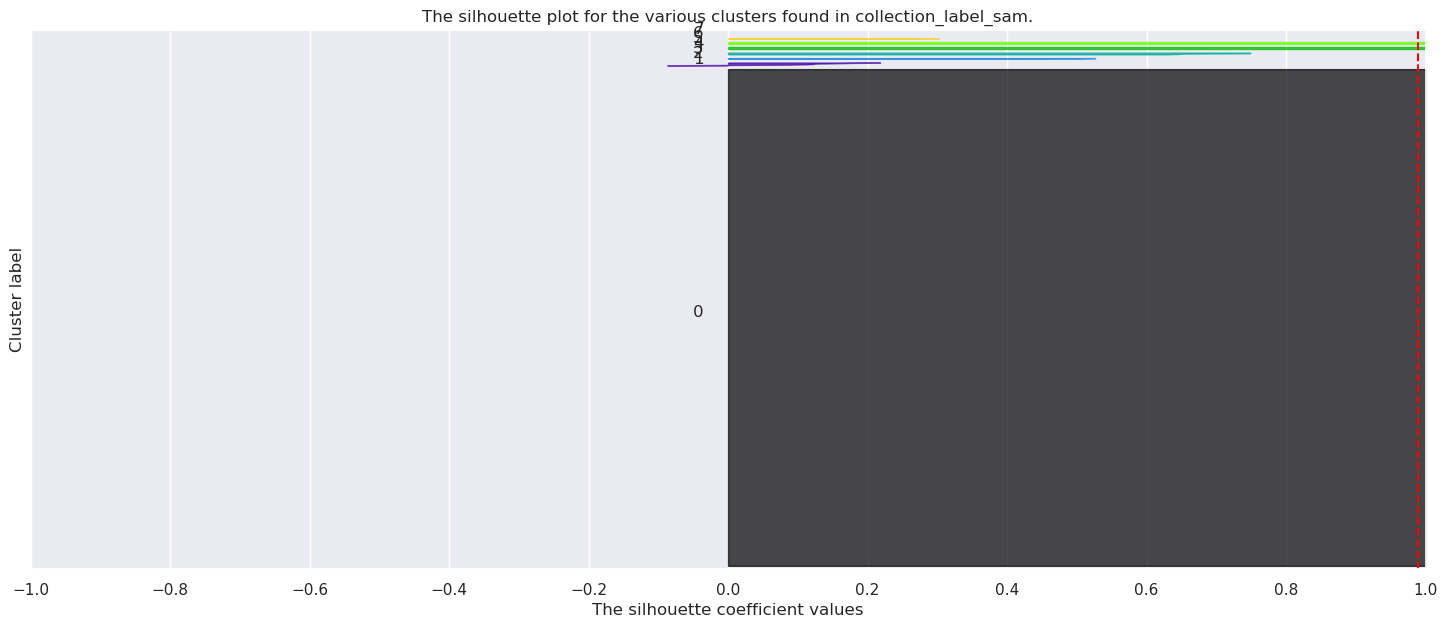


comments_sam
1.0000007 0.0 0.8654076 1.0000007152557373
Estimated no. of clusters: 33
Estimated no. of noise points: 107
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.47922608


<Figure size 640x480 with 0 Axes>

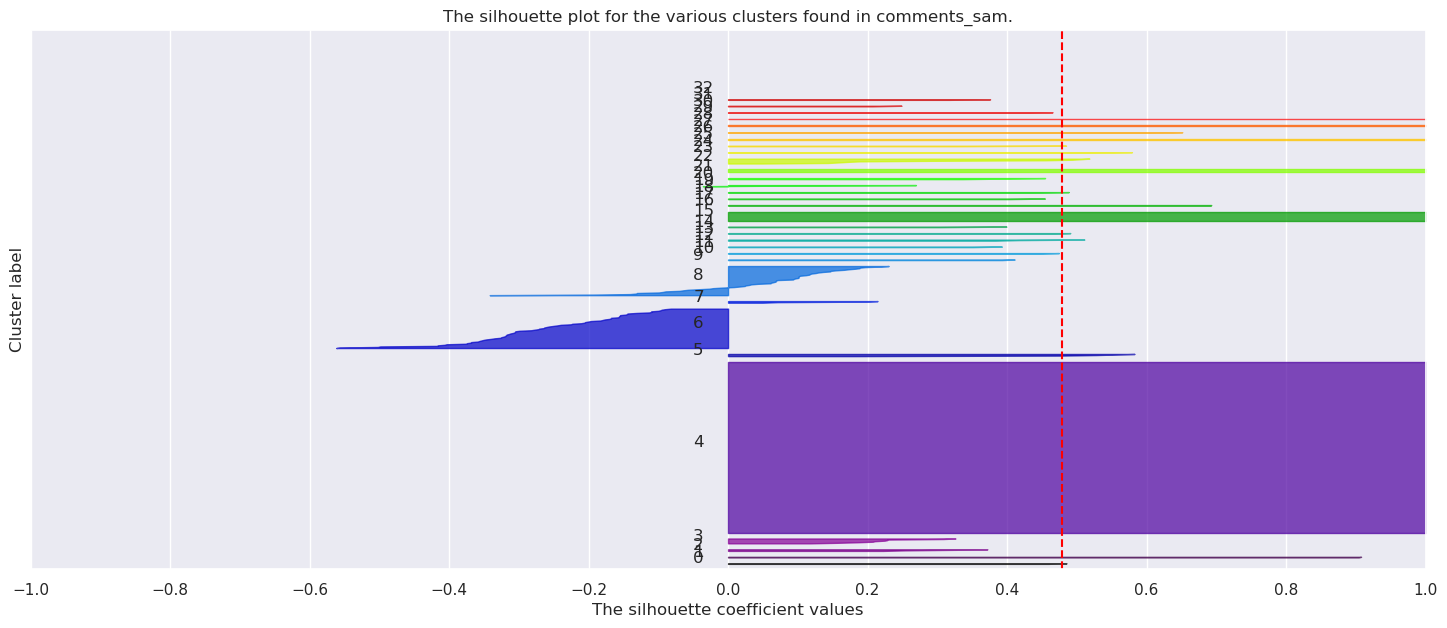


conductivity_sam
1.0000007 0.0 0.59150904 1.0000007152557373
Estimated no. of clusters: 3
Estimated no. of noise points: 3
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.24337848


<Figure size 640x480 with 0 Axes>

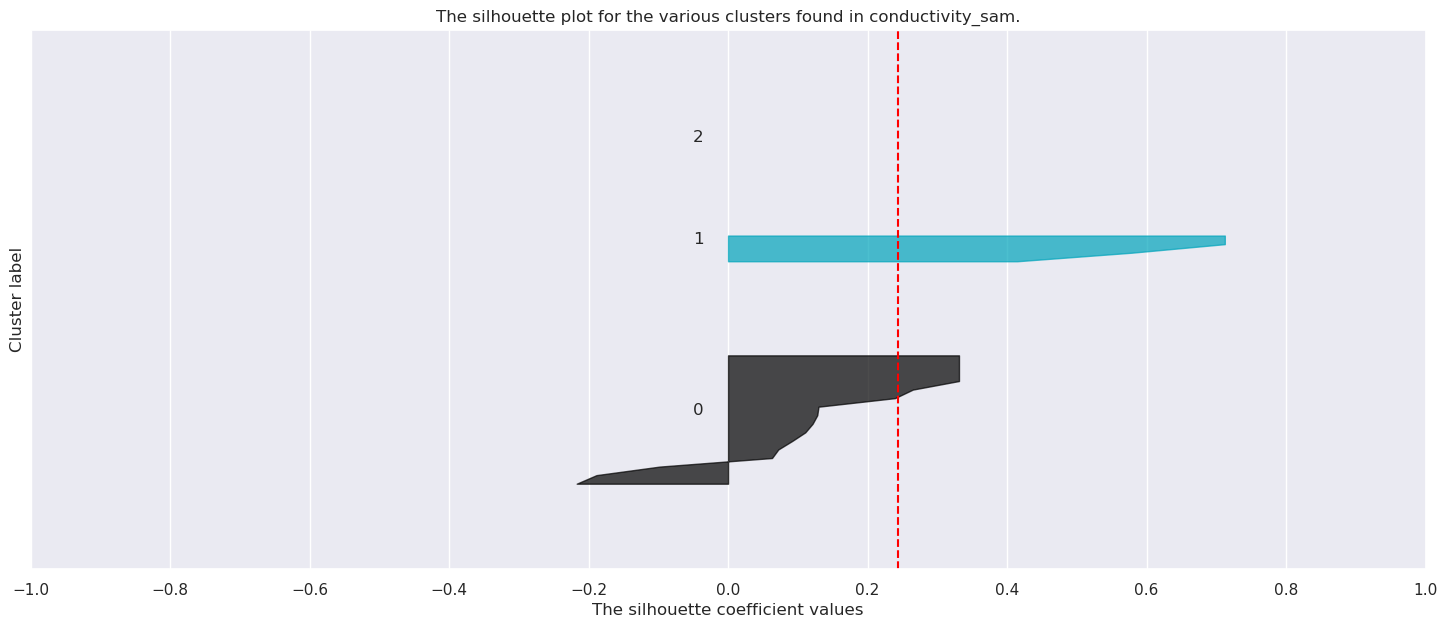


corrected_species_name_sam
1.0000007 0.0 0.5591744 1.0000007152557373
Estimated no. of clusters: 29
Estimated no. of noise points: 182
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: -0.010948957


<Figure size 640x480 with 0 Axes>

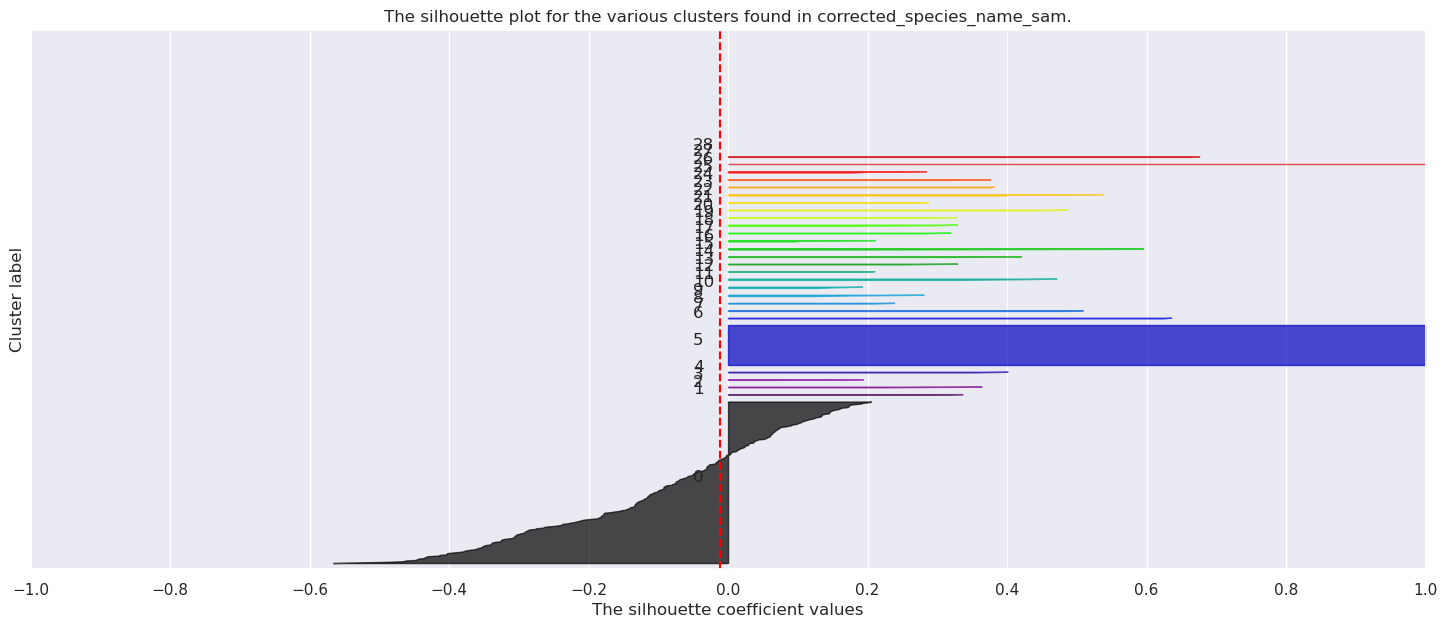


coverage_sam
1.0000004 0.0 0.86117685 1.0000003576278687
Estimated no. of clusters: 4
Estimated no. of noise points: 0
DBSCAN(eps=1.0000003577278687, min_samples=2)
silhouette score: 0.7091814


<Figure size 640x480 with 0 Axes>

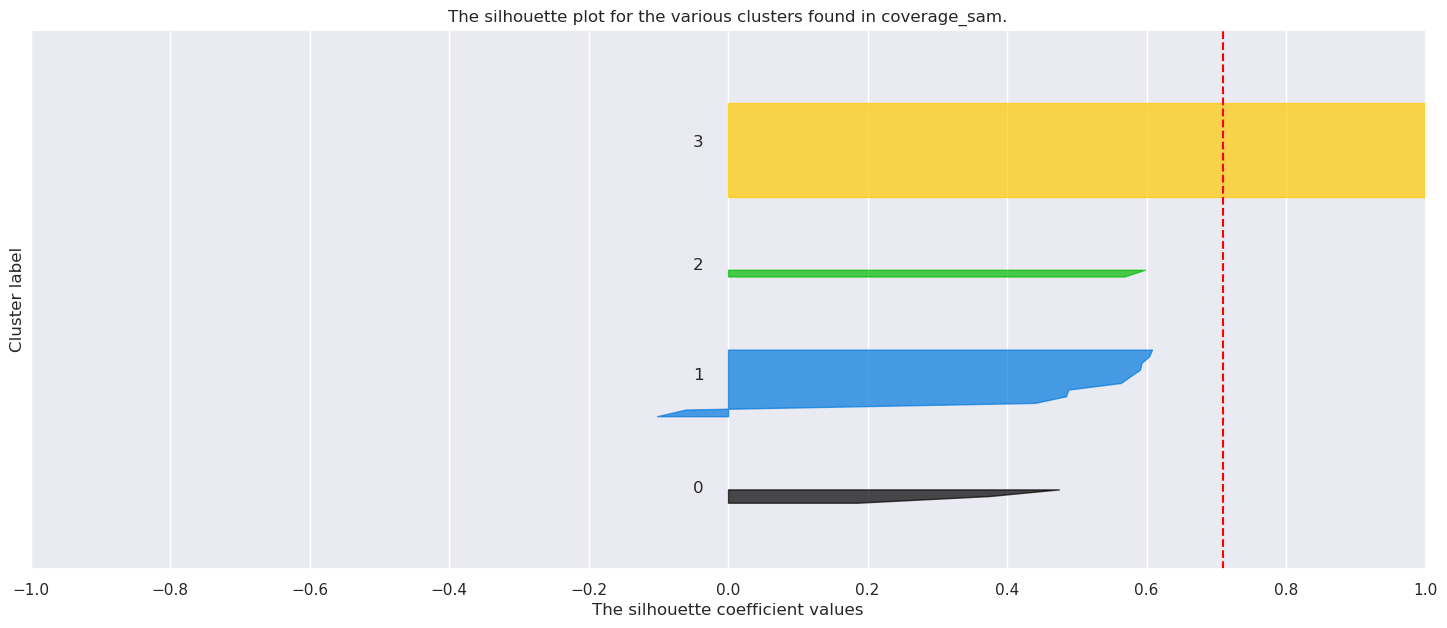


date_of_birth_sam
1.0000007 0.0 0.9999981 1.0000007152557373
Estimated no. of clusters: 3
Estimated no. of noise points: 2
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.9989398


<Figure size 640x480 with 0 Axes>

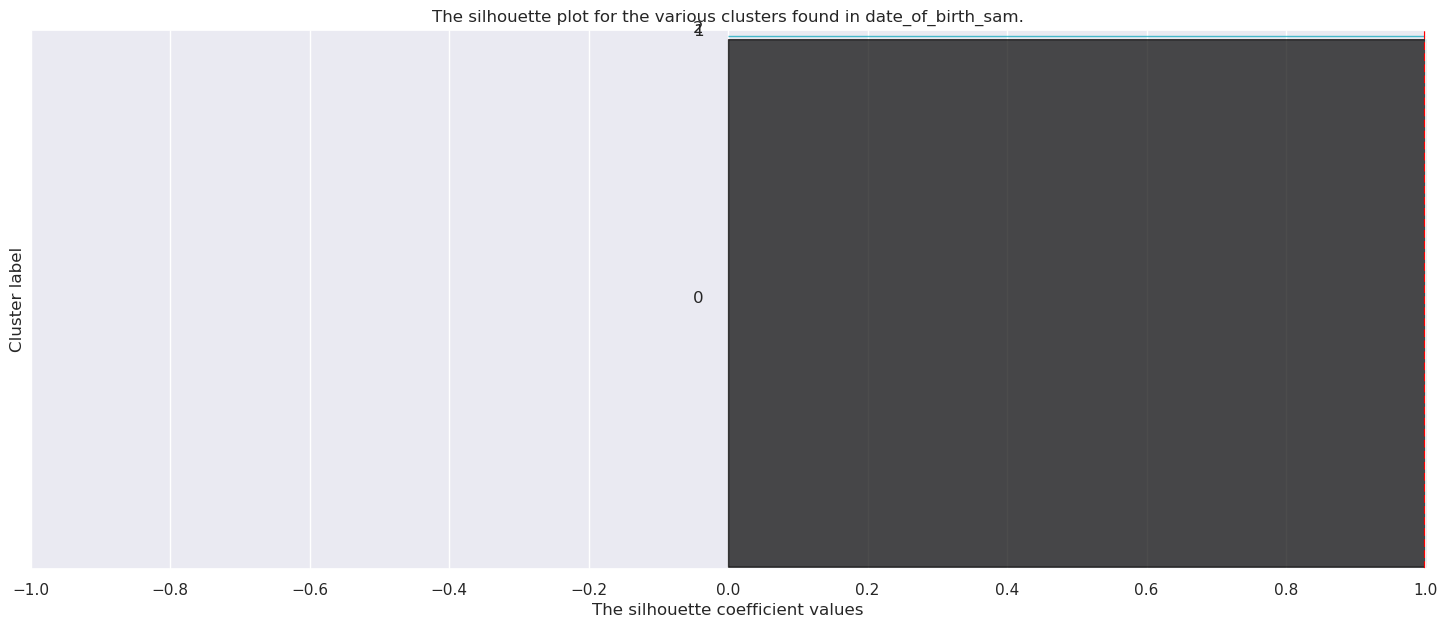


derived_from_sam
1.0000006 0.0 0.6685752 1.0000005960464478
Estimated no. of clusters: 3
Estimated no. of noise points: 0
DBSCAN(eps=1.0000005961464478, min_samples=2)
silhouette score: 0.8566056


<Figure size 640x480 with 0 Axes>

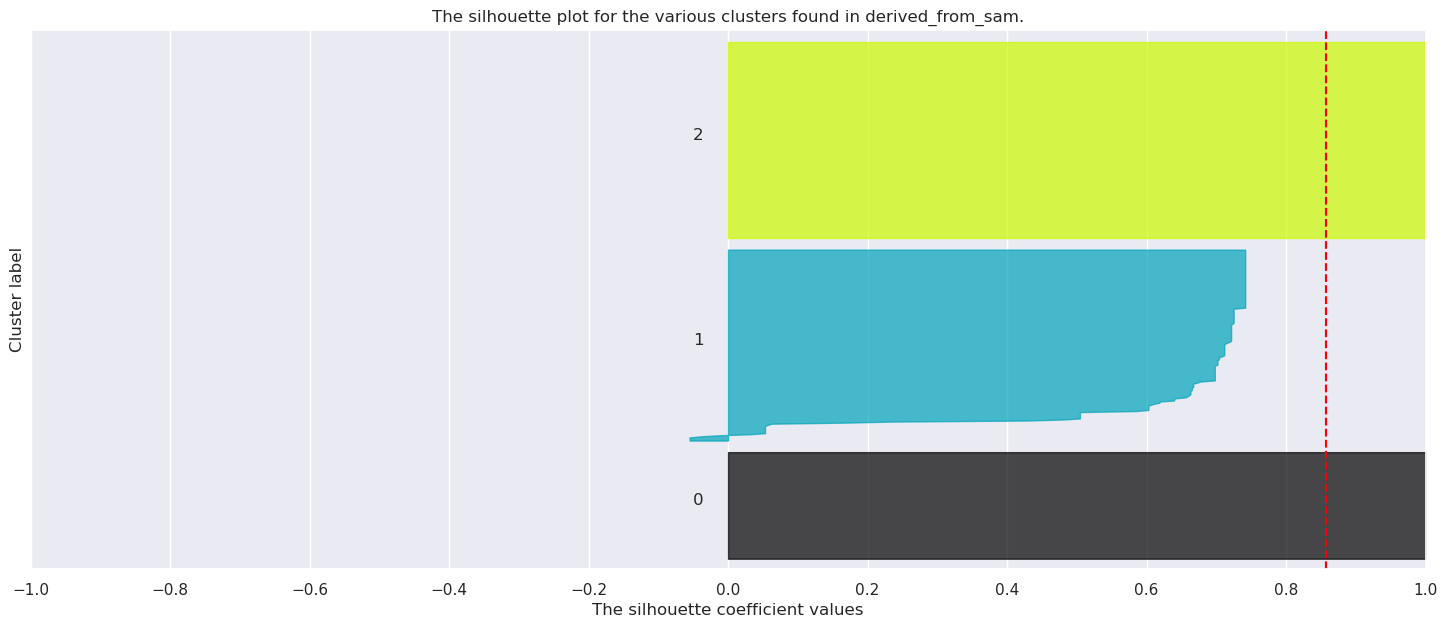


description_exp
1.0000005 0.0 0.9965463 1.0000004768371582
Estimated no. of clusters: 12
Estimated no. of noise points: 6
DBSCAN(eps=1.0000004769371582, min_samples=2)
silhouette score: 0.9824282


<Figure size 640x480 with 0 Axes>

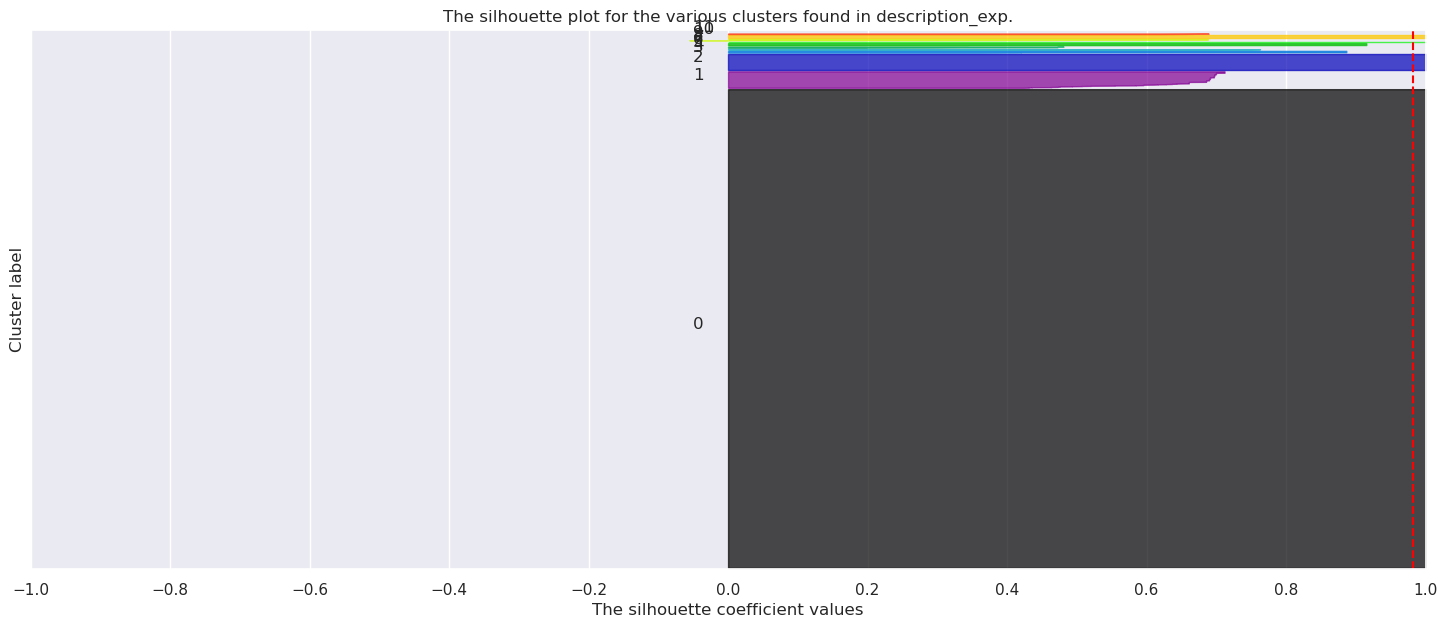


description_sam results not found at ./results/fasttext-similarity-matrix/fasttext-description_sam.similarity-score-matrix.npy

descriptor_sam
1.0000005 0.0 0.17838125 1.0000004768371582
Estimated no. of clusters: 12
Estimated no. of noise points: 7
DBSCAN(eps=1.0000004769371582, min_samples=2)
silhouette score: 0.9865379


<Figure size 640x480 with 0 Axes>

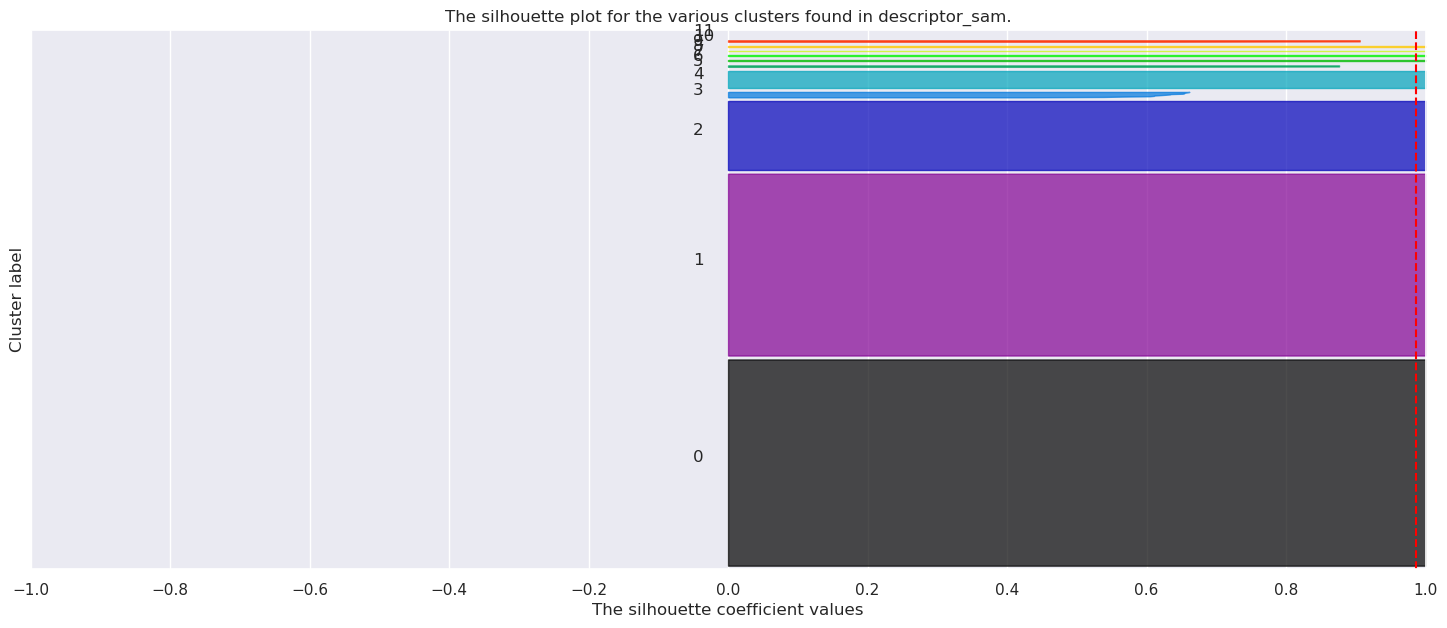


details_sam
1.0000007 0.0 0.92751515 1.0000007152557373
Estimated no. of clusters: 20
Estimated no. of noise points: 8
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.94038504


<Figure size 640x480 with 0 Axes>

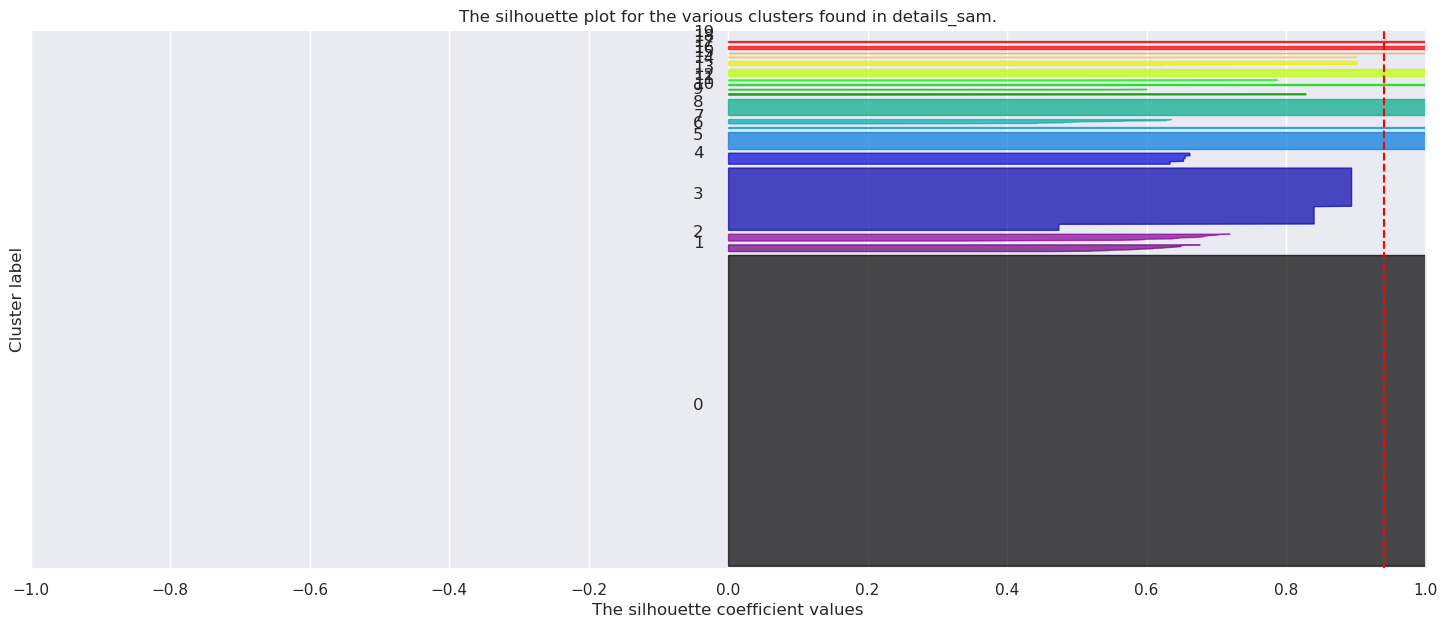


diagnostic_pcr_ct_value_1_sam
1.0000004 0.0 0.92235994 1.0000003576278687
Estimated no. of clusters: 6
Estimated no. of noise points: 14
DBSCAN(eps=1.0000003577278687, min_samples=2)
silhouette score: 0.9486325


<Figure size 640x480 with 0 Axes>

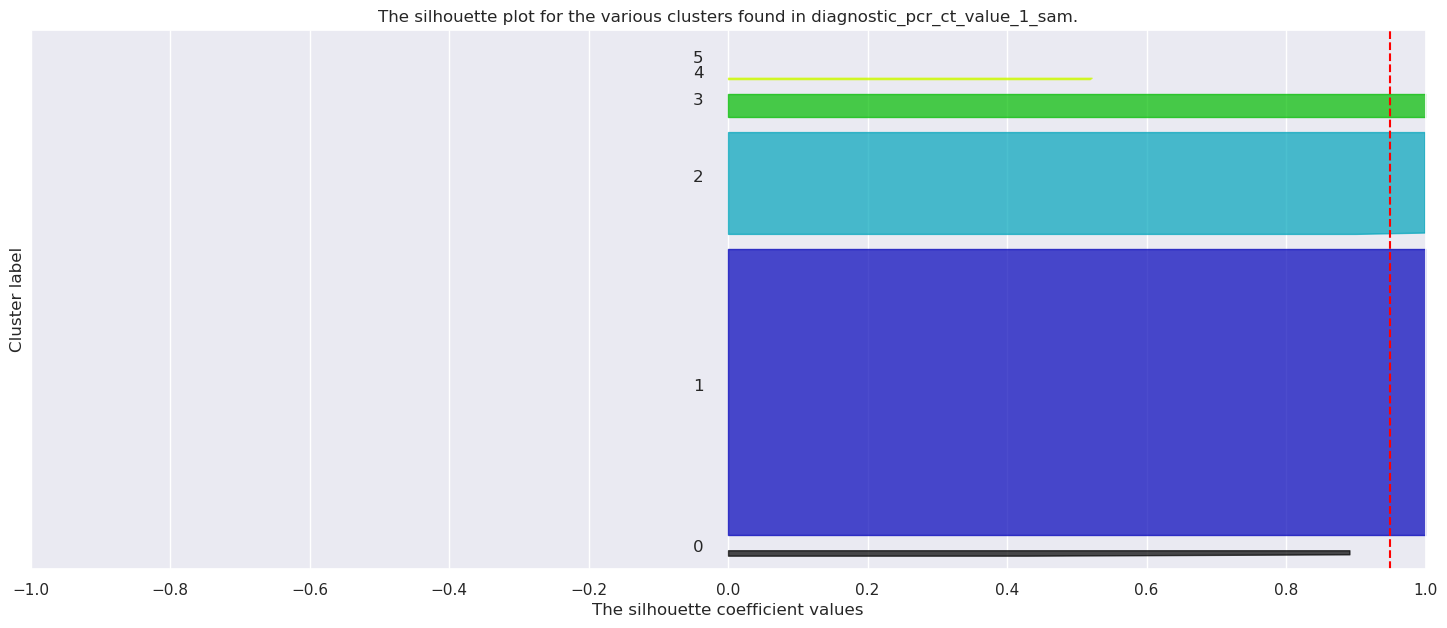


dissolved_oxygen_sam
1.0000007 0.0 0.99482036 1.0000007152557373
Estimated no. of clusters: 4
Estimated no. of noise points: 2
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.93299484


<Figure size 640x480 with 0 Axes>

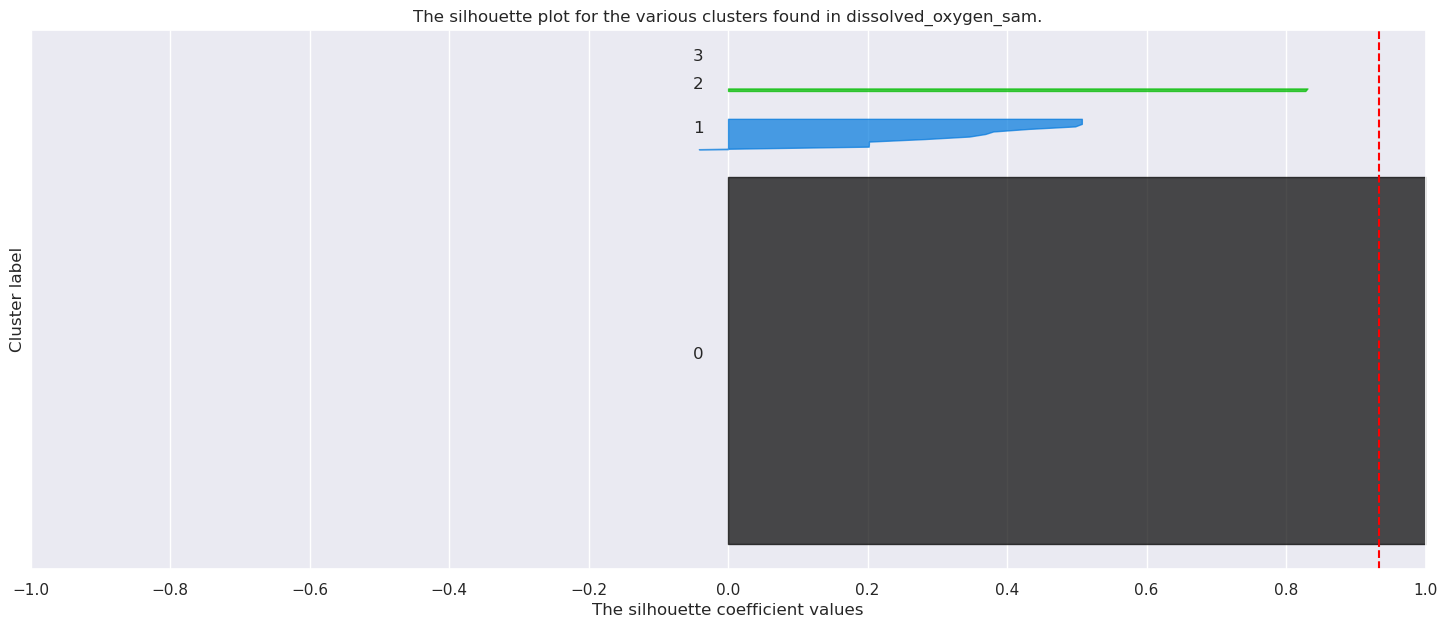


experimental_factor__rna_interference_exp
1.0000005 0.0 0.3295314 1.0000004768371582
Estimated no. of clusters: 16
Estimated no. of noise points: 38
DBSCAN(eps=1.0000004769371582, min_samples=2)
silhouette score: 0.65469307


<Figure size 640x480 with 0 Axes>

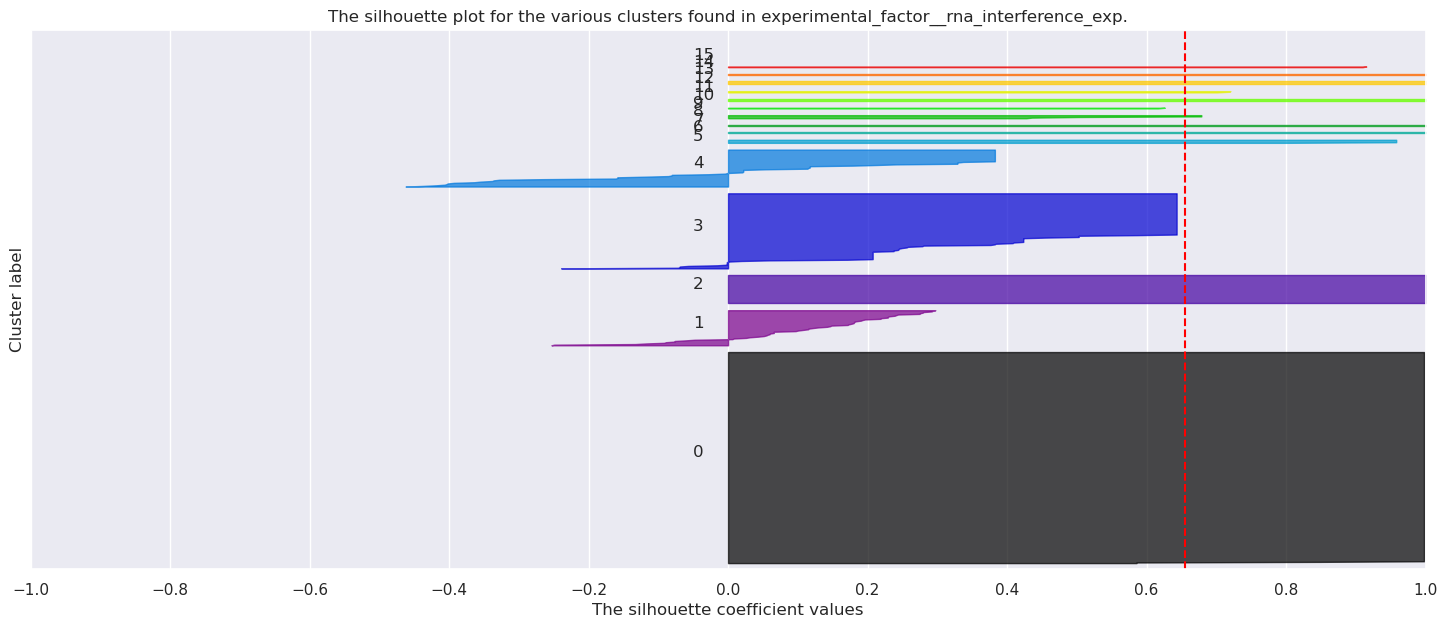


experimental_factor__strain_exp
1.0379477 0.0 0.99603474 1.037947654724121
Estimated no. of clusters: 33
Estimated no. of noise points: 41
DBSCAN(eps=1.0000004769371582, min_samples=2)
silhouette score: 0.9214332


<Figure size 640x480 with 0 Axes>

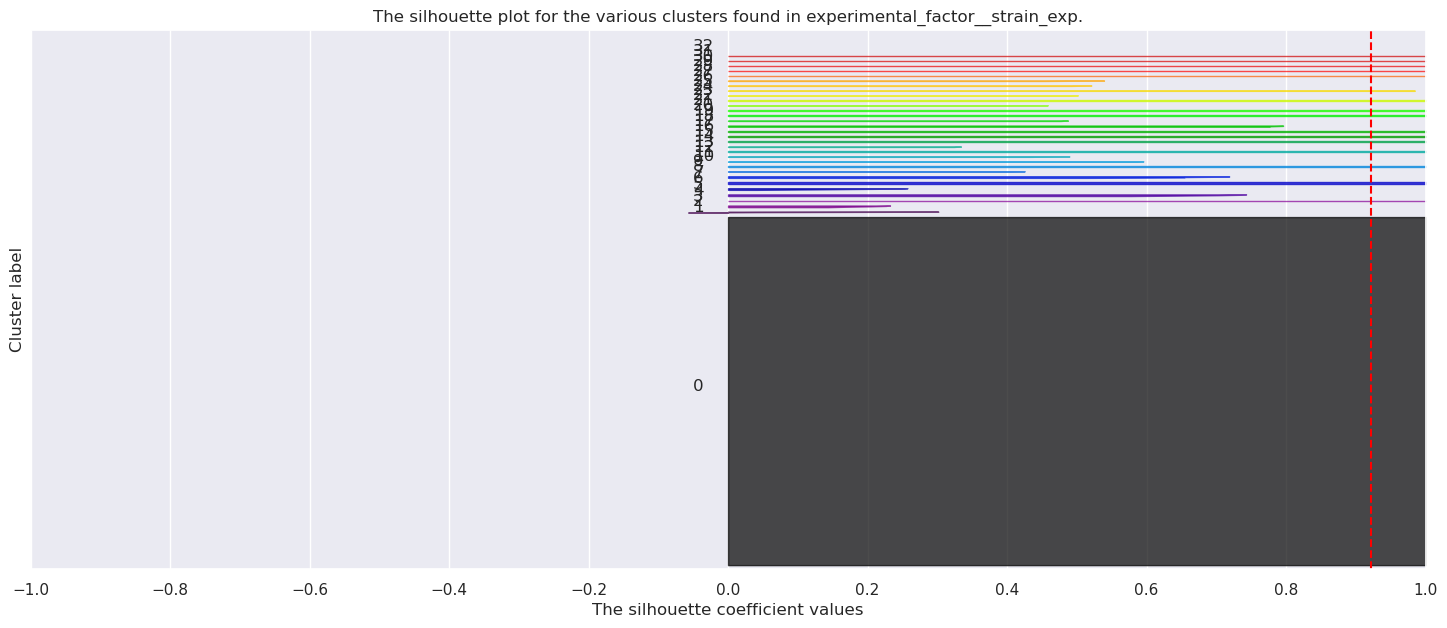


extra_info_sam
0.90354913 0.0 0.5716588 0.9035491347312927
Estimated no. of clusters: 4
Estimated no. of noise points: 5
DBSCAN(eps=0.8404338658855988, min_samples=2)
silhouette score: 0.15785846


<Figure size 640x480 with 0 Axes>

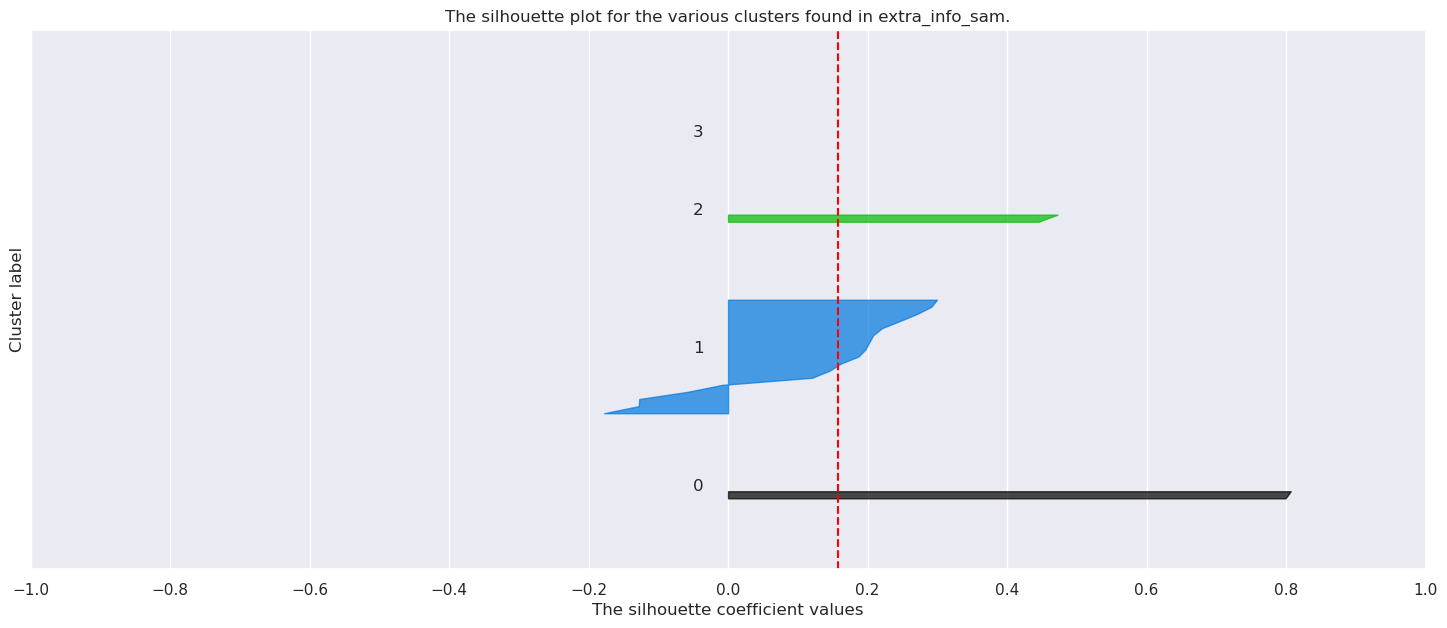


fiber_sam
1.0000004 0.0 0.9910788 1.0000003576278687
Estimated no. of clusters: 3
Estimated no. of noise points: 0
DBSCAN(eps=1.0000003577278687, min_samples=2)
silhouette score: 0.90411264


<Figure size 640x480 with 0 Axes>

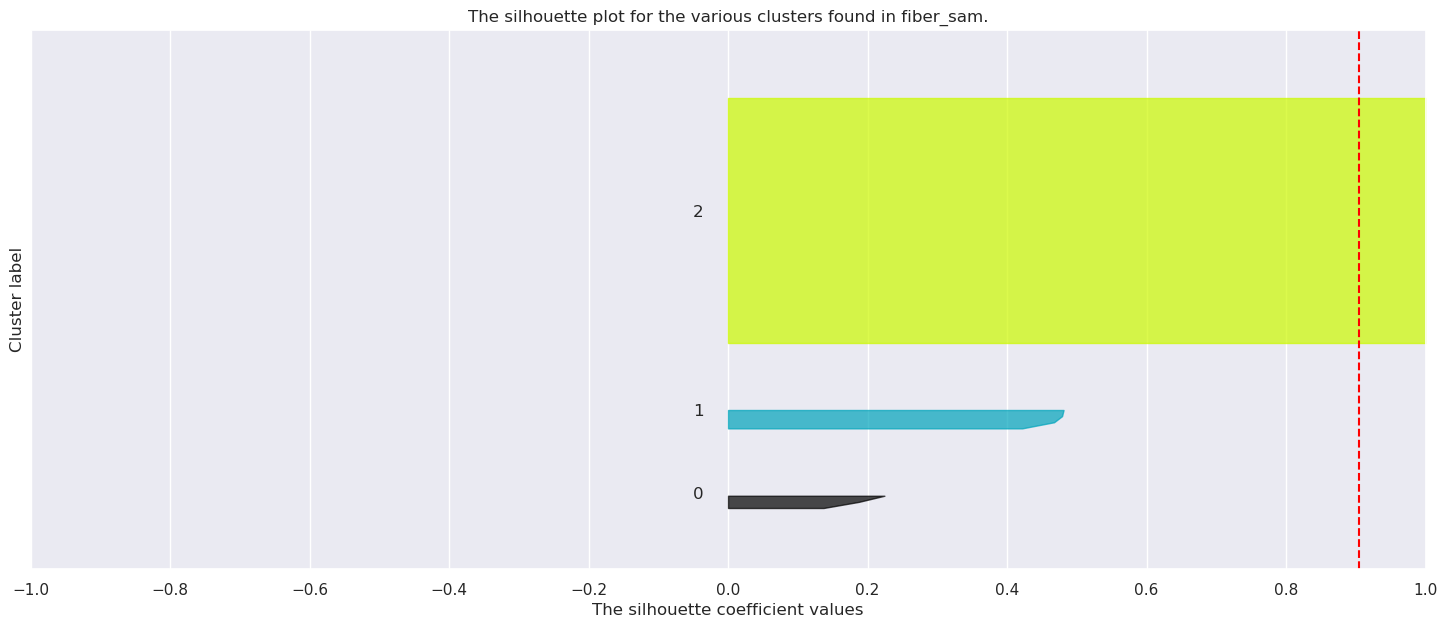


glucose_sam
1.0000007 0.0 0.97690874 1.0000007152557373
Estimated no. of clusters: 4
Estimated no. of noise points: 3
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: 0.83487326


<Figure size 640x480 with 0 Axes>

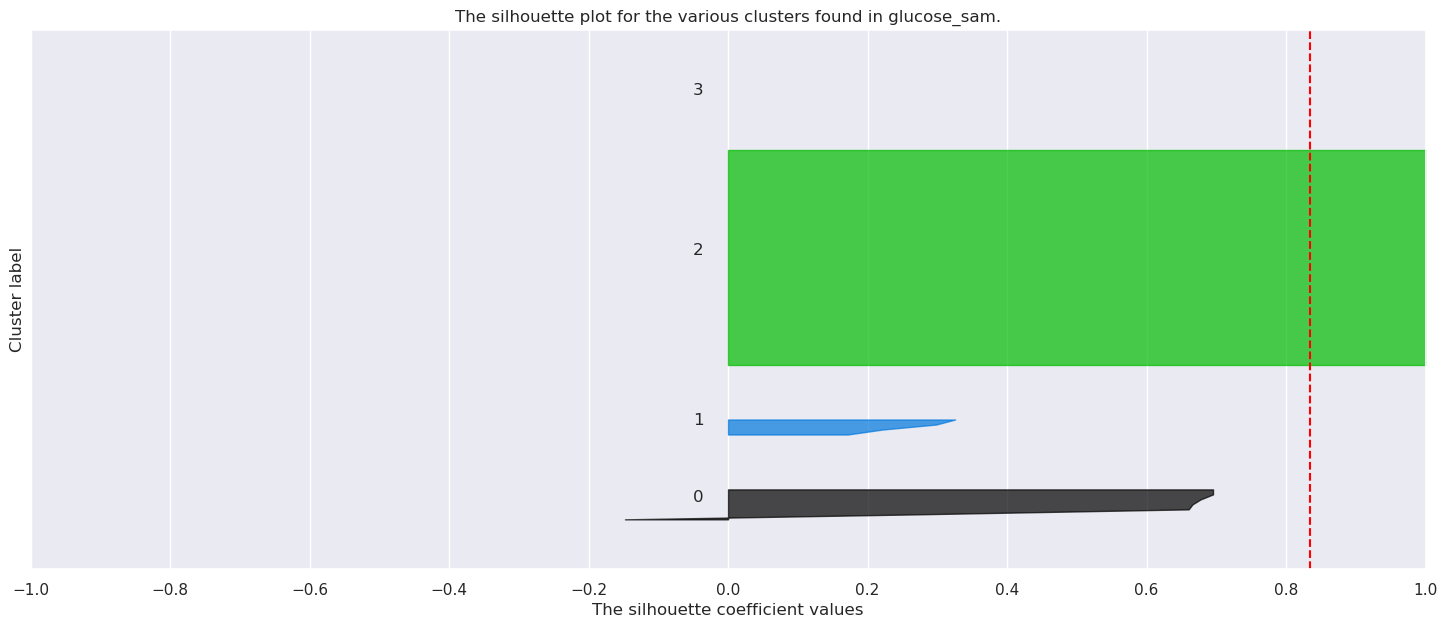


host_exp
0.83326036 0.0 0.3128242 0.8332603573799133
Estimated no. of clusters: 2
Estimated no. of noise points: 1
DBSCAN(eps=0.8298082948731018, min_samples=2)
silhouette score: 0.70544165


<Figure size 640x480 with 0 Axes>

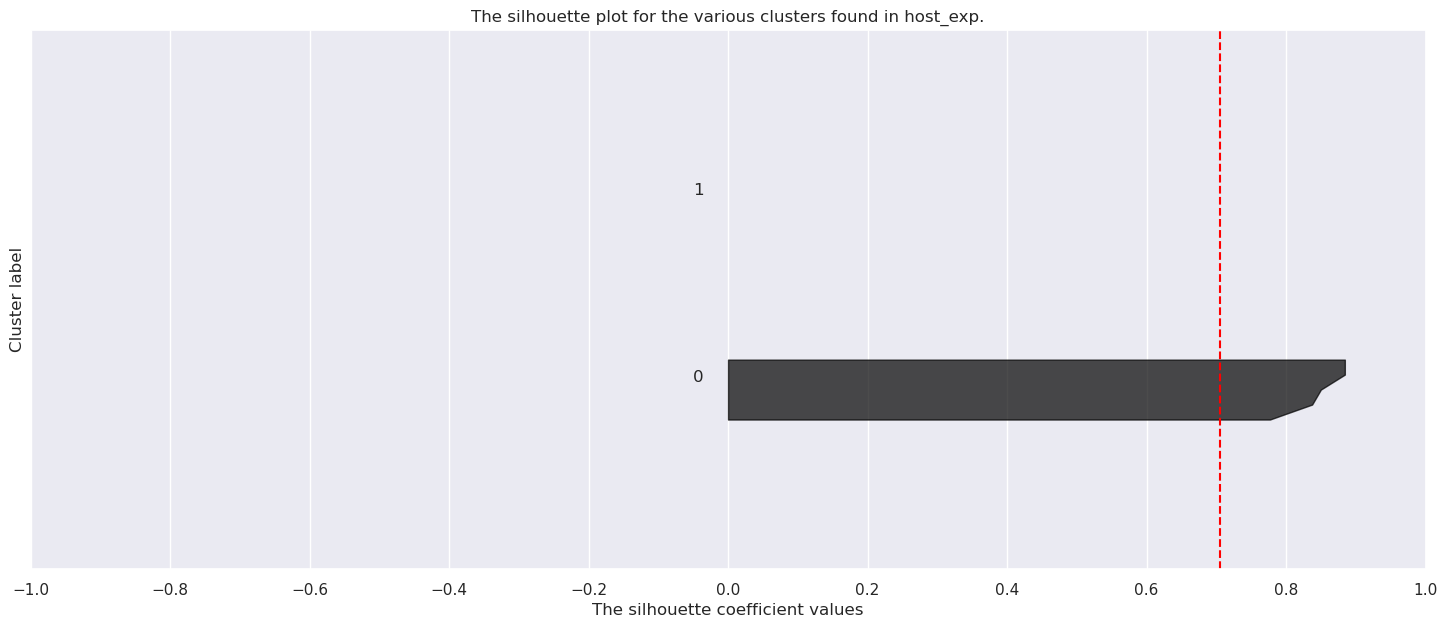


host_scietific_nam_sam
1.0000007 0.0 0.44017193 1.0000007152557373
Estimated no. of clusters: 32
Estimated no. of noise points: 253
DBSCAN(eps=1.0000007153557373, min_samples=2)
silhouette score: -0.17199847


<Figure size 640x480 with 0 Axes>

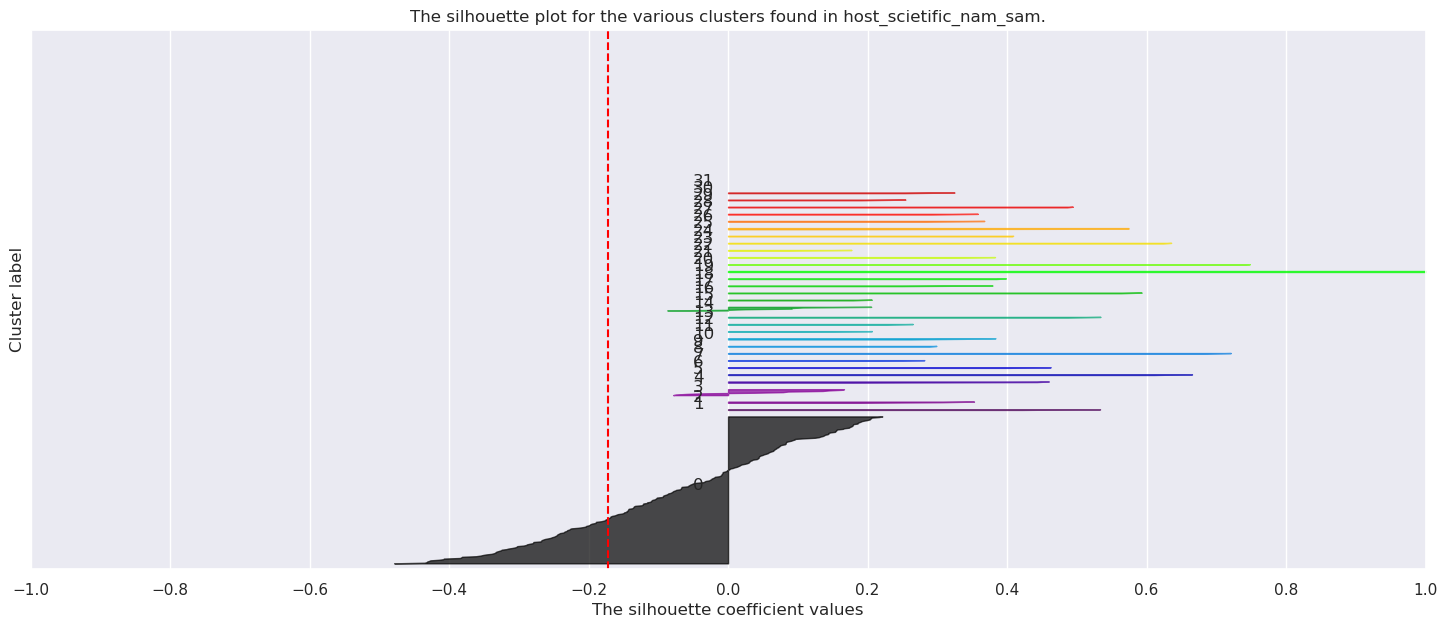

In [ ]:
groupings_dict = {}
for a in vocab_df1.field.unique():
    f1 = "./results/fasttext-similarity-matrix/fasttext-{attribute}.similarity-score-matrix.npy".format(attribute=a)
    if not os.path.exists(f1):
        print(a, 'results not found at', f1)
        print("")
        continue
    f2 = "./attributes/{attribute}.entries.tsv".format(attribute=a)
    if not os.path.exists(f2):
        print(a, 'results not found at', f2)
        print("")
        continue
    else:
        test2_np = np.load(f1)
        #print(a, 'first load success')
        test2_np = np.nan_to_num(test2_np)
        test2_np = test2_np.max() - test2_np
        test2 = pd.DataFrame(test2_np)
        test2_md = pd.read_csv(f2, sep='\t', header=None)
        #print(a, 'second load success')

        
        clustering = DBSCAN(eps=0.0000000001+test2.quantile(q=0.75).quantile(q=1), min_samples=2).fit(test2_np)
        labels = clustering.labels_
        no_clusters = len(np.unique(labels) )
        no_noise = np.sum(np.array(labels) == -1, axis=0)
        test2_sm = test2.copy(deep=True)
        test2_sm['labels'] = labels
        test2_sm = test2_sm[['labels']]
        for i in test2_sm.index:
            test2_sm.at[i, 'Value'] = test2_md[0].loc[i]
        groupings = [test2_sm[test2_sm.labels==i].Value.to_list() for i in test2_sm.labels.unique()]
        groupings_dict.update({a: groupings})
        if len(set(labels))>1:
            ss = silhouette_score(test2_np, labels)

            # Create a subplot with 1 row and 2 columns
            fig, ax1 = plt.subplots(1, 1)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(test2_np) + (no_clusters + 1) * 10])
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(test2_np, labels)

            y_lower = 10
            for i in range(no_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / no_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters found in {a}.".format(a=a))
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=ss, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        print(a)
        print(test2.max().max(), test2.min().min(), test2.mean().mean(), test2.quantile(q=1).quantile(q=1))
        print('Estimated no. of clusters: %d' % no_clusters)
        print('Estimated no. of noise points: %d' % no_noise)
        print(clustering)
        if len(set(labels))>1:
            print('silhouette score:', ss)
        plt.show()
        plt.savefig('{a}_fasttext_silhouette.png')
        plt.clf()
        print('')

In [11]:
for x in groupings_dict['fiber_sam']:
    print(x)

['numeric', 'number', 'not collected']
['cellulose', 'pectin', 'fiber free', 'pea fiber']
['16,90', '19,30', '15,20', 'cellulose/pectin', '42,40', '36,40', '52,10', '23,90', '16,80', '37,30', '29,40', '24,70', '11,50', '31,50', '31,60', '20,60', '15,60', '20,20', '14,60', '20,30', '36,10', '26,90', '13,80', '13,20', '41,10', '22,00', '34,10', '27,60', '5,90', '19,50', '55,10', '14,80', '57,60', '73,80', '58,90', '47,40', '48,00', '27,20', '58,10', '23,20', '12,20']


In [92]:
test2_np.max()

1.0000007